In [1]:
#import scipy.stats as spss
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob,os
import pandas as pd
#import hddm
#from kabuki import utils
import gc


plt.style.use('seaborn-ticks')
RTdata = pd.read_csv('DDM/dataHDDM_rt.csv')

In [2]:
RTdata.response =  RTdata.apply(lambda x: 1 if x["stim"]==x["response"] else 0, axis=1)
RTdata.rt = RTdata.rt*1000

In [16]:
def QPplot(data, syndata, name, variable="RT"): #Rather slow...
    fig, ax = plt.subplots(2,1, figsize=[5,7], dpi=300)
    for SAT, SAT_dat in data.groupby('SAT'):
        Prec, RTQuantiles, subject, contrast = [],[],[],[]
        meanPrec, meanRT,synmeanPrec, synmeanRT = [],[],[],[]
        meanRT_sub, meanPrec_sub,synmeanRT_sub, synmeanPrec_sub = [],[],[],[]
        for participant, part_dat in SAT_dat.groupby('participant'):    
            con_meanRT, con_meanPrec,syncon_meanRT, syncon_meanPrec = [],[],[],[]
            for con, con_dat in SAT_dat.groupby("contrast"):
                corr_meanRT, corr_meanPrec,syncorr_meanRT, syncorr_meanPrec = [],[],[],[]
                for corr, corr_dat in con_dat.groupby("response"):
                    corr_meanRT.append(corr_dat.rt.quantile([.1,.3,.5,.6,.9]).values)
                    corr_meanPrec.append(np.repeat(float(len(corr_dat.response))/len(con_dat),5))
                    syn_subset = syndata[(syndata.contrast == con) & (syndata.SAT == SAT)]
                    syncorr_meanRT.append(syn_subset[syn_subset.response == corr].groupby('sample').rt.quantile([.1, .3,.5,.6,.9]))
                    syncorr_meanPrec.append(np.repeat(syn_subset[syn_subset.response == corr].groupby('sample').response.count()/syn_subset.groupby('sample').response.count(),5))
                con_meanRT.append(corr_meanRT)
                con_meanPrec.append(corr_meanPrec)
                syncon_meanRT.append(syncorr_meanRT)
                syncon_meanPrec.append(syncorr_meanPrec)
            meanRT_sub.append(con_meanRT)
            meanPrec_sub.append(con_meanPrec)
            synmeanRT_sub.append(syncon_meanRT)
            synmeanPrec_sub.append(syncon_meanPrec)

        meanRT.append([np.mean(meanRT_sub, axis=0)])
        meanPrec.append([np.mean(meanPrec_sub, axis=0)])
        meanRT, meanPrec = np.asarray(meanRT[0][0]), np.asarray(meanPrec[0][0])

        synmeanRT.append([np.mean(synmeanRT_sub, axis=0)])
        synmeanPrec.append([np.mean(synmeanPrec_sub, axis=0)])
        synmeanRT, synmeanPrec = np.asarray(synmeanRT[0][0]),np.asarray(synmeanPrec[0][0])

        if SAT =="Accuracy":
            curax = ax[0]
        else:
            curax = ax[1]

        ys = synmeanRT
        colors =  plt.cm.Set3.colors[:6]
        colors = np.array(colors)[[2,0,5,4,1,3],:]
        i = 0
        for y in ys:
            curax.scatter(synmeanPrec[i].flatten(), y.flatten(), marker=".", alpha=.2, color=colors[i])
            curax.plot(meanPrec[i].flatten(),meanRT[i].flatten(), 'x', color="k")
            i += 1

        if curax==ax[1]:
            curax.set_xlabel("Response proportion")
        curax.set_ylabel("%s quantiles (ms)"%variable)
        curax.set_xlim(0,1)
        curax.vlines(.5,0,2000,linestyle=':')

        if SAT == "Accuracy":
            curax.annotate('Correct', xy=(.9, 1200), xytext=(.51,1200),
                         arrowprops={'arrowstyle': '->'}, va='center')
            curax.annotate('Errors', xy=(.1, 1200), xytext=(.38,1200),
                         arrowprops={'arrowstyle': '->'}, va='center')
            curax.plot( [0,0],  [0,0],'x', label="Data", color='k')
            curax.plot( [0,0],  [0,0],'.', label="Model", color='gray', markerfacecolor="w", markeredgecolor="gray", alpha=.2)
            curax.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
            curax.set_title('%s'%name)
            curax.set_ylim([250, 1300])
        else : 
            curax.set_ylim([150, 850])
    plt.tight_layout()
    plt.savefig('DDM/QPplot/%s.png'%name)
    plt.show() 


In [17]:
def generate_predictions(fit, pathname, n_samples=250):
        gen_data = hddm.utils.post_pred_gen(fit, samples=n_samples)
        gen_data.reset_index(inplace=True)
        gen_data.rt = np.abs(gen_data.rt)*1000
        gen_data[["FC","SAT","contrast","expdResp","participant"]] = gen_data['node'].str.split('.', expand=True)
        gen_data.contrast = [float("0."+x) for x in gen_data.contrast]
        gen_data.expdResp = gen_data.apply(lambda x: "Left" if x["expdResp"]=="0)" else "Right", axis=1)
        gen_data.FC = [x[5:] for x in gen_data.FC]
        gen_data["givenResp"] = gen_data.apply(lambda x: "Left" if x["response"]==0 else "Right", axis=1)
        gen_data.response = gen_data.apply(lambda x: 1 if x["givenResp"]==x["expdResp"] else 0, axis=1)
        gen_data.contrast = gen_data.contrast.replace(gen_data.contrast.unique(), gen_data.contrast.unique())
        gen_data.contrast = [int(x) for x in gen_data.contrast]
        gen_data.to_csv(pathname)
        return gen_data

## GRaphing QPplot, computing DIC and BPIC

________________________________
 Model M13 : 



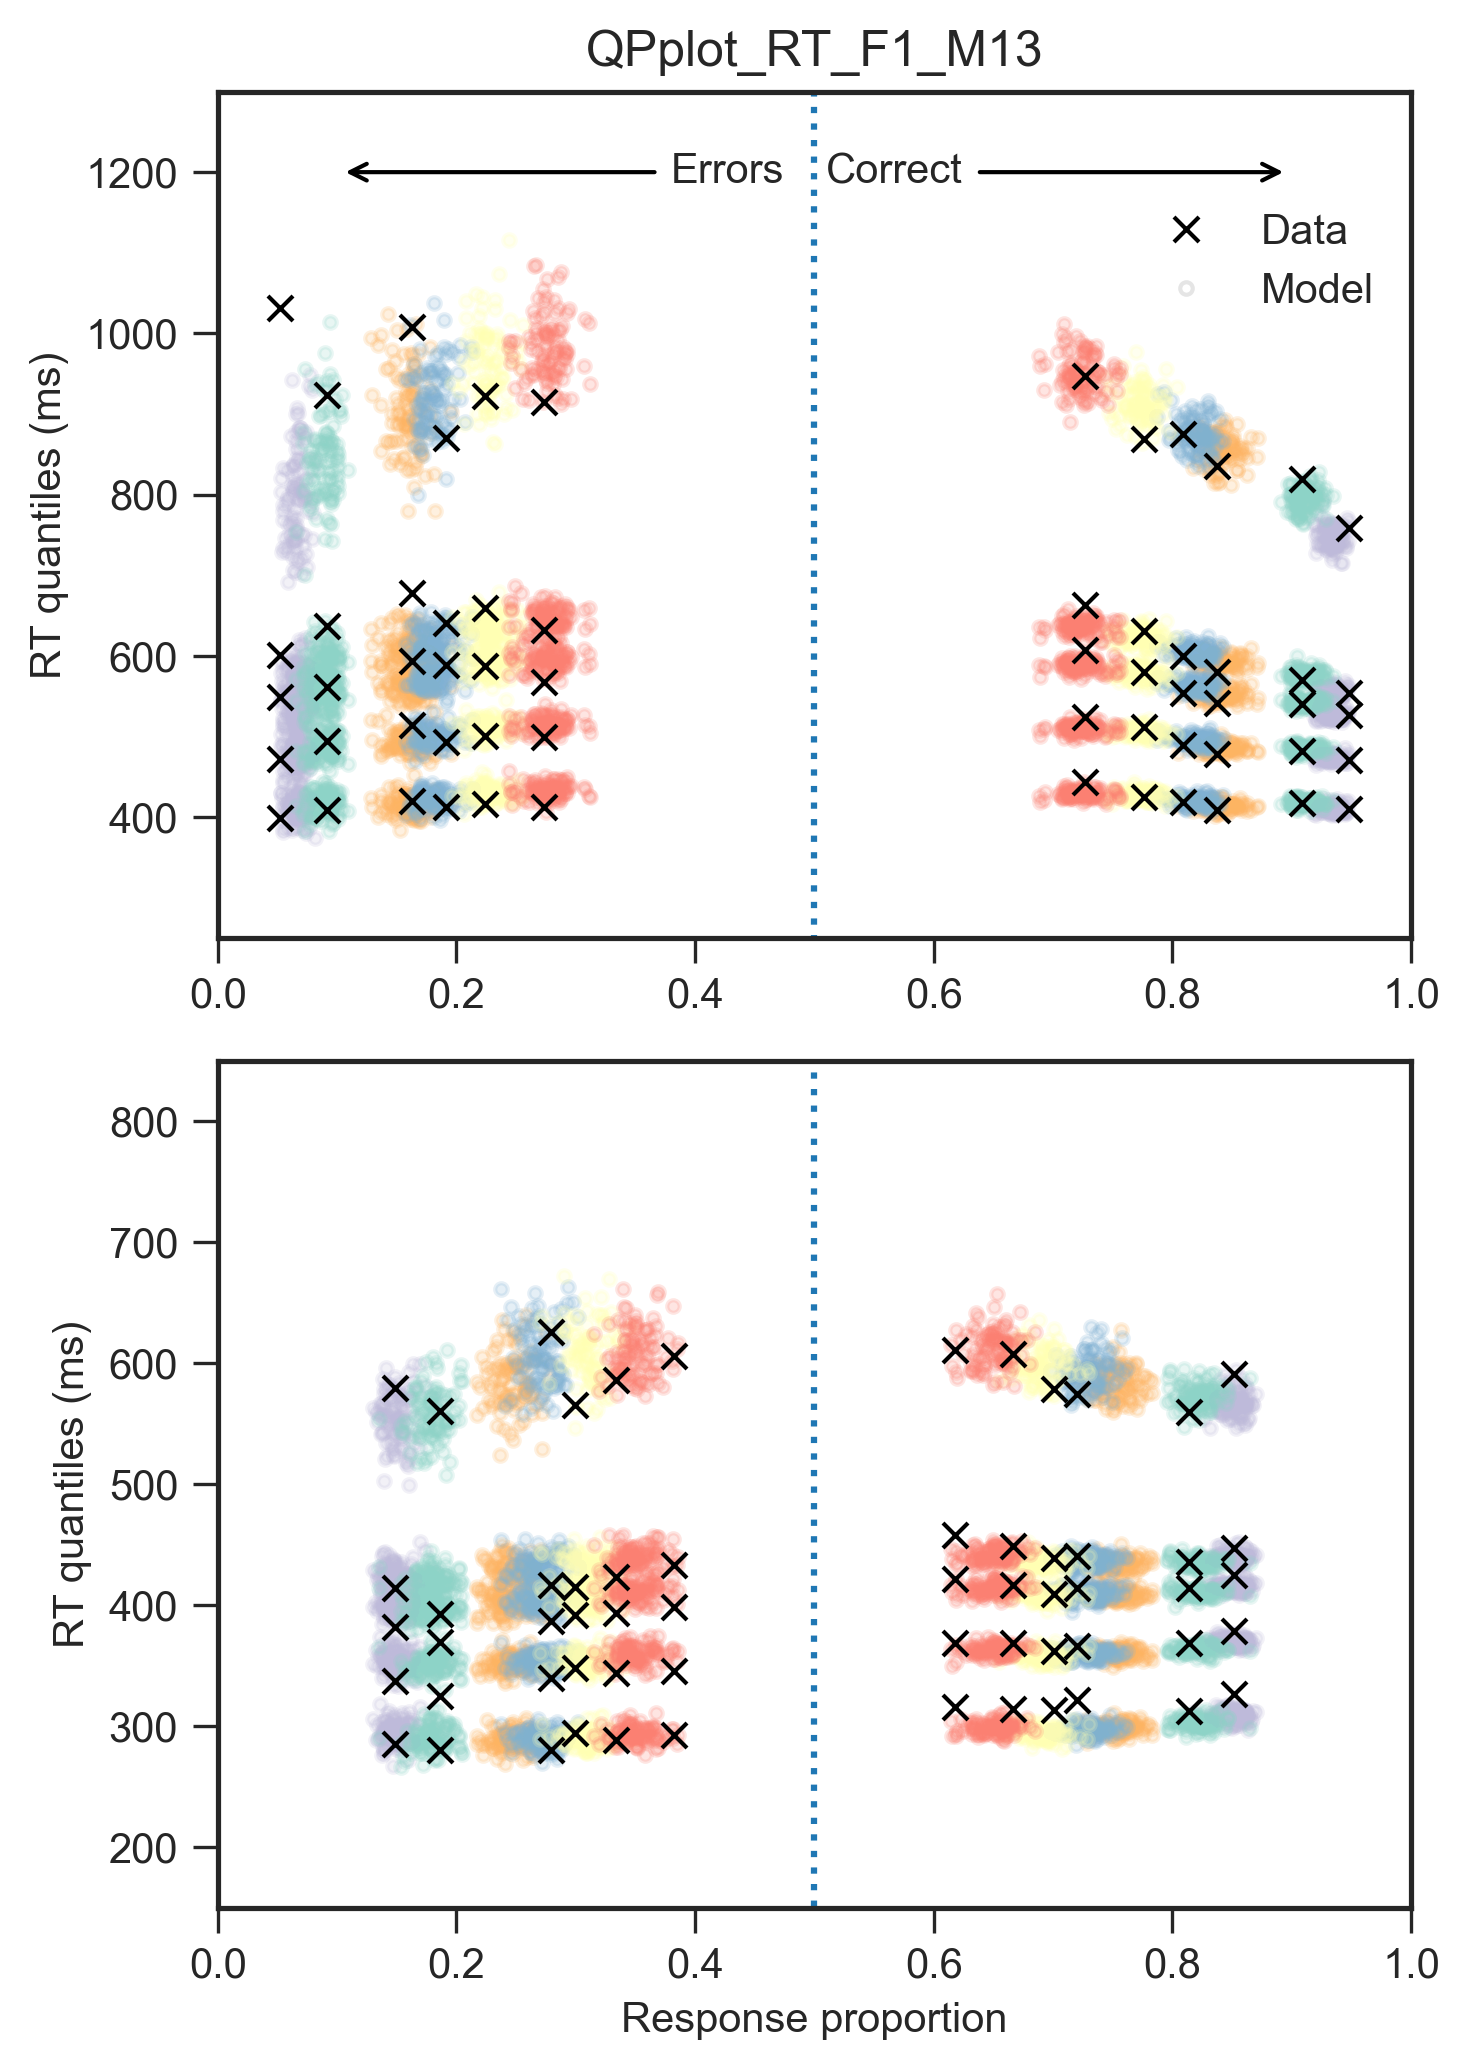

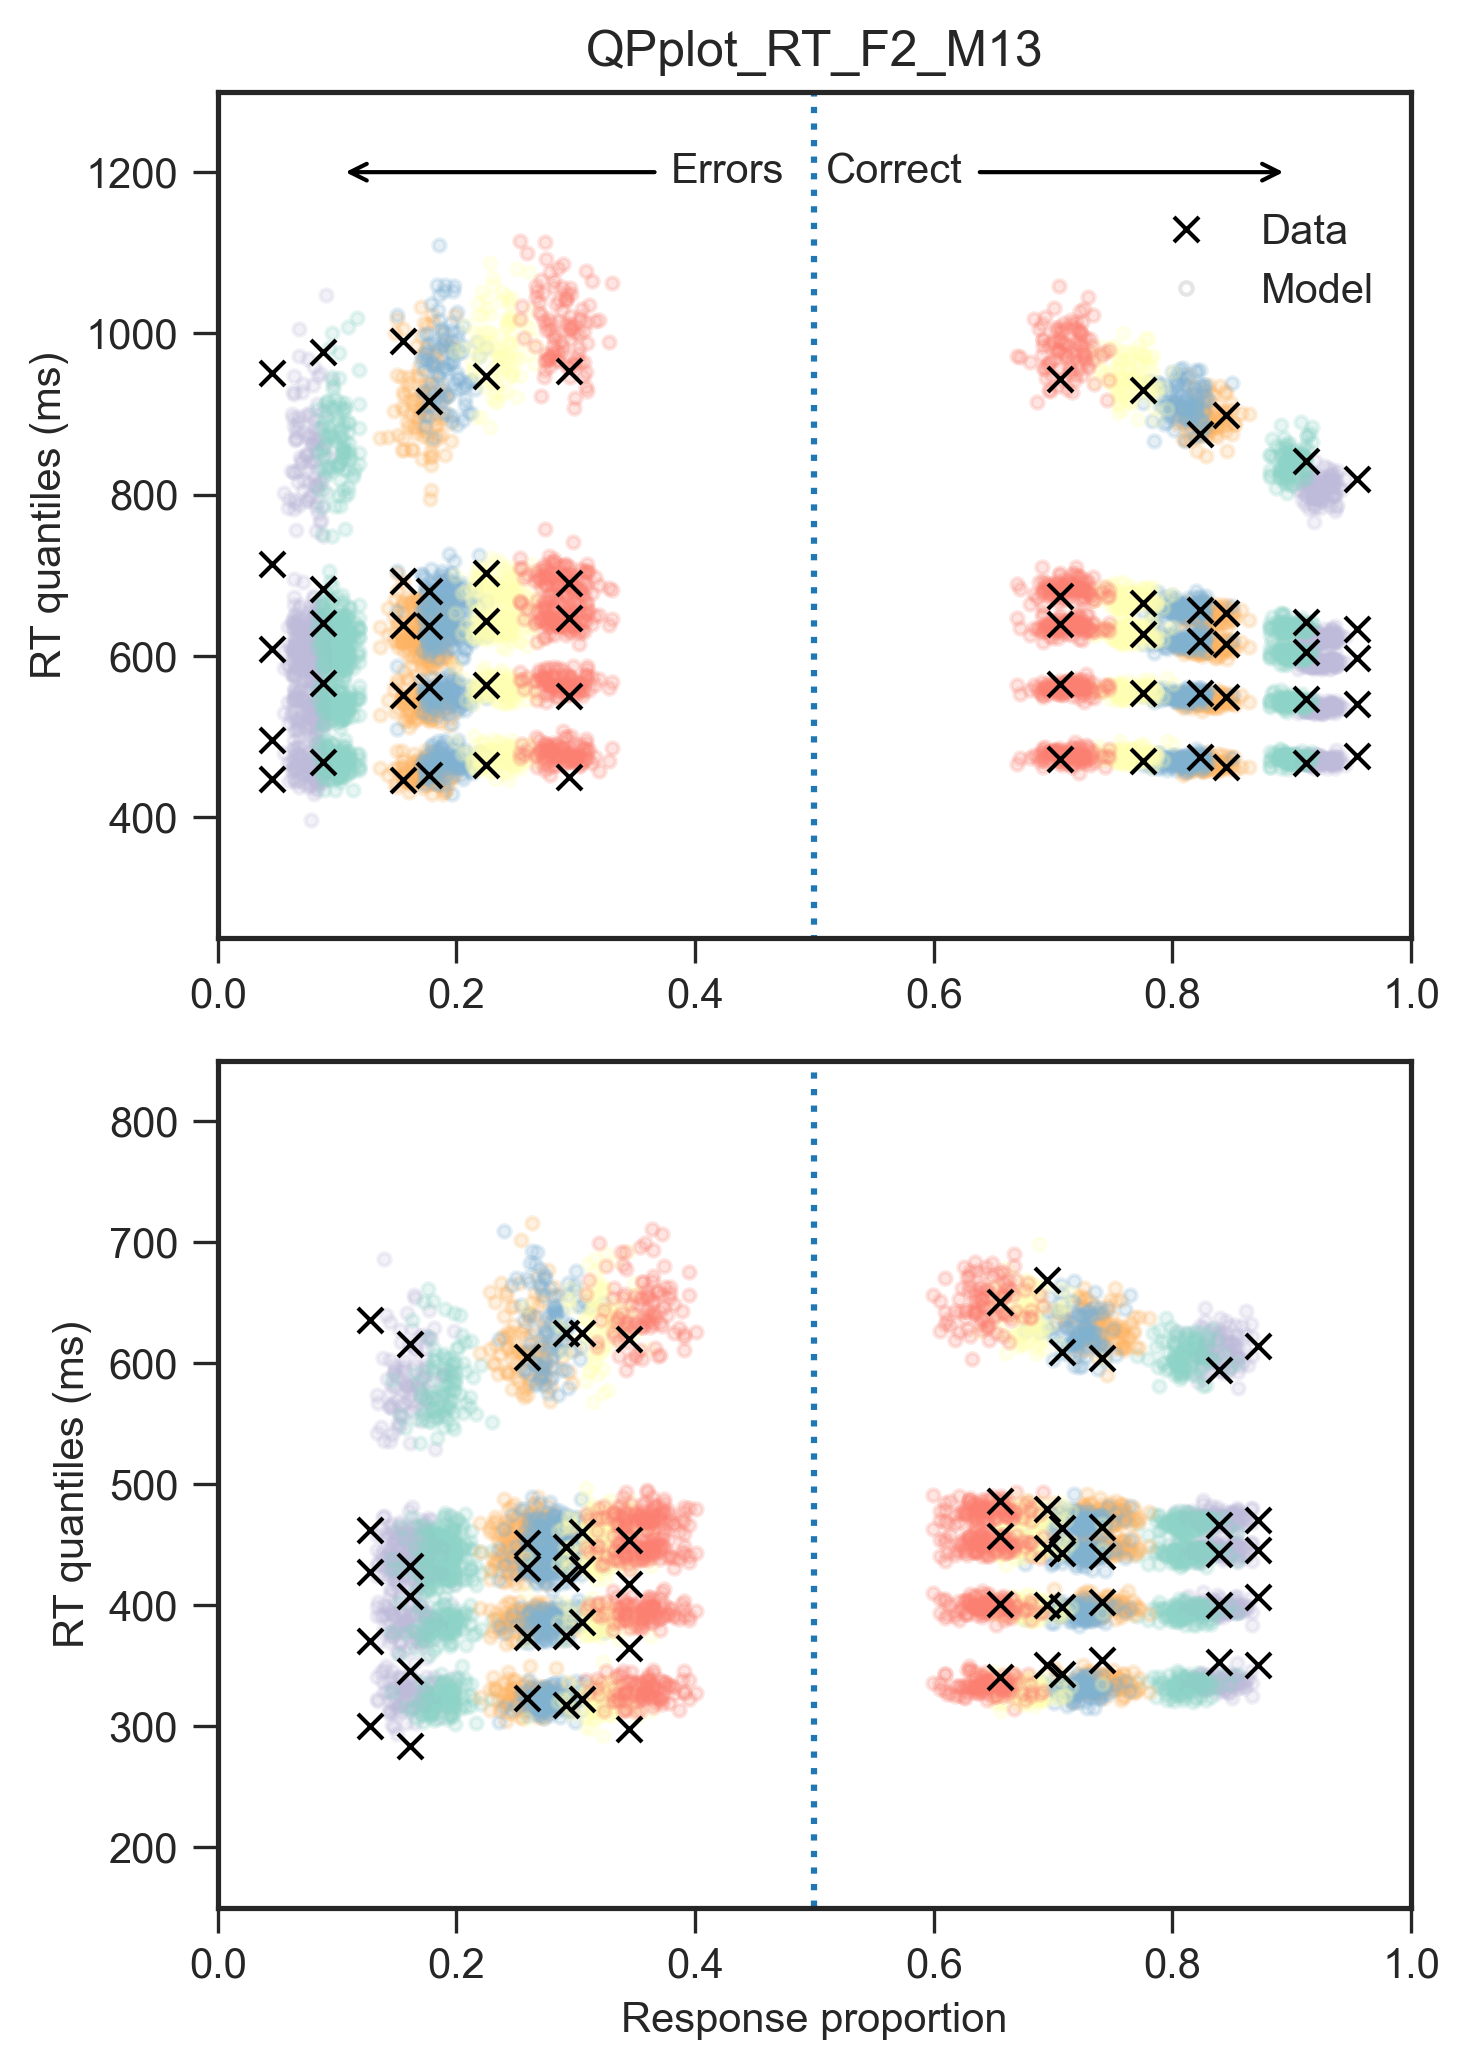

In [20]:
RTdata_F1 = RTdata[RTdata.FC == "low"]
RTdata_F2 = RTdata[RTdata.FC == "high"]

DIC = []
BPIC = []

for model in ["M13"]:#"M1","M2","M3","M4","M5","M6","M7","M8","M9","M10","M11","M12","M13","M14","M15","M16"]:
    print("________________________________\n Model %s : \n"%model)
    #fit = []
    #for f in os.listdir(os.curdir + '/DDM/Fits/'):
    #    if "RT_%s_"%model in f and 'light' not in f and 'reg' not in f:
    #        fit.append(hddm.load("DDM/Fits/%s"%f))
    #fit = utils.concat_models(fit)
    
    generated_data_file = 'simulated_data_RTfit_%s.csv'%model
    if generated_data_file not in os.listdir(os.curdir+'/DDM/QPplot/'):
        gen_RT_data = generate_predictions(fit, os.curdir+'/DDM/QPplot/%s'%generated_data_file, n_samples=100)
    else : 
        gen_RT_data = pd.read_csv('DDM/QPplot/%s'%generated_data_file)
    
    #DIC.append(fit.dic)
    #BPIC.append(fit.mc.BPIC)
    
    #print("DIC %s = %f \n"%(model, DIC[-1]))
    #print("BPIC %s = %f \n"%(model, BPIC[-1]))
    
    #f = open("DDM/DIC_RT.txt", "a")
    #f.write("%s : %s \n"%(model, DIC[-1]))
    #f.close()
    
    #f = open("DDM/BPIC_RT.txt", "a")
    #f.write("%s : %s \n "%(model, BPIC[-1]))
    #f.close()
    gen_RT_data.contrast = [int(x) for x in gen_RT_data['node'].str.split('.', expand=True)[2]]
    
    gen_RT_data_F1 = gen_RT_data[gen_RT_data.FC == "low"]
    QPplot(RTdata_F1, gen_RT_data_F1, 'QPplot_RT_F1_%s'%model)
    plt.show()
    gen_RT_data_F2 = gen_RT_data[gen_RT_data.FC == "high"]
    QPplot(RTdata_F2, gen_RT_data_F2, 'QPplot_RT_F2_%s'%model)
    plt.show()
    gc.collect()